# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_147  P08571              21.210
Sample_017  Q9UHG2              21.140
Sample_185  A0A087X0D5;P09668   18.277
Sample_151  P01008              21.666
Sample_082  Q08ET2              15.819
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                          
Sample_009  Q9P1W8;Q9P1W8-2;Q9P1W8-4                   16.235
Sample_023  P34059                                     13.360
Sample_121  Q86X29;Q86X29-4;Q86X29-5;Q86X29-6;S4R3V8   14.906
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.468
            A0A075B6Q5                 13.308
            A0A075B6R2                 11.736
            A0A075B6S5                 12.069
            A0A087WSY4                 13.299
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.839
            Q9UI40;Q9UI40-2            12.879
            Q9UIW2                     12.792
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.266
            Q9UP79                     13.555
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.464,15.050,16.842,19.863,15.989,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.431,19.067,...,15.528,15.576,14.223,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.904,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.783,17.705,17.039,14.978,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.636,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.801,15.345,17.084,18.708,14.249,19.433,11.614,10.915
Sample_207,15.739,16.877,15.469,16.898,14.796,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.159,13.777,12.640,12.489,13.610,12.832,12.033,11.305,12.727,12.746
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.537,19.067,16.127,...,10.830,14.386,11.364,13.451,11.817,13.663,12.653,12.576,13.234,12.766
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.672,12.815,13.203,12.465,11.195,13.141,12.695,13.647,11.638,12.753
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.398,12.298,13.608,12.549,12.974,13.272,12.898,12.061,12.881,13.489
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.166,13.003,12.466,12.482,13.264,13.554,13.258,13.447,12.497,13.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.012,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 391.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

100%|██████████| 2/2 [00:00<00:00,  8.62it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.21it/s]

100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

100%|██████████| 3/3 [00:00<00:00,  6.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.44it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.13it/s]

100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

100%|██████████| 4/4 [00:00<00:00,  5.85it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.97it/s]

100%|██████████| 5/5 [00:00<00:00,  4.85it/s]

100%|██████████| 5/5 [00:00<00:00,  5.18it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.73it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.40it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.95it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.68it/s]

100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.40it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.69it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.79it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  4.69it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.54it/s]

100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.67it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.94it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.31it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.12it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.41it/s]

100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

100%|██████████| 8/8 [00:01<00:00,  4.46it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.13it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.67it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.38it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.02it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.97it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.18it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.27it/s]

100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.24it/s]

 30%|███       | 3/10 [00:00<00:01,  5.32it/s]

 40%|████      | 4/10 [00:00<00:01,  4.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.31it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.09it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.80it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.96it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.06it/s]

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 10.12it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.04it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.70it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.40it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.26it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.99it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  4.02it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.14it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

100%|██████████| 11/11 [00:02<00:00,  4.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.36it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.77it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.07it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.62it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.38it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.18it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.12it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.13it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.97it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.13it/s]

100%|██████████| 12/12 [00:02<00:00,  4.17it/s]

100%|██████████| 12/12 [00:02<00:00,  4.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.48it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.38it/s]

 31%|███       | 4/13 [00:00<00:02,  3.67it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.44it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.15it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.02it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.74it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.52it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.49it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.60it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.52it/s]

100%|██████████| 13/13 [00:04<00:00,  2.62it/s]

100%|██████████| 13/13 [00:04<00:00,  2.91it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.08it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.48it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.19it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.32it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.35it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.62it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.73it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.78it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.84it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.81it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.82it/s]

100%|██████████| 14/14 [00:03<00:00,  4.05it/s]

100%|██████████| 14/14 [00:03<00:00,  3.71it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.53it/s]

 20%|██        | 3/15 [00:00<00:02,  4.98it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.38it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.03it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.87it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.79it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.74it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.88it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.07it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.17it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.44it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.68it/s]

100%|██████████| 15/15 [00:04<00:00,  3.77it/s]

100%|██████████| 15/15 [00:04<00:00,  3.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.041 0.013          0.696 0.392       0.100   
2             0.004 0.002      0.041 0.014          0.711 0.091       0.599   
3             0.004 0.002      0.037 0.007          0.767 0.109       0.632   
4             0.004 0.003      0.042 0.014          0.715 0.095       0.681   
5             0.004 0.003      0.044 0.015          0.787 0.092       0.810   
6             0.004 0.003      0.043 0.013          0.785 0.091       0.814   
7             0.004 0.003      0.043 0.016          0.813 0.086       0.820   
8             0.005 0.004      0.044 0.014          0.818 0.087       0.823   
9             0.004 0.003      0.042 0.014          0.813 0.079       0.830   
10            0.004 0.002      0.038 0.013          0.809 0.082       0.831   
11            0.004 0.002      0.037 0.014          0.814 0.077       0.824   
12            0.004 0.002      0.035 0.011          0.817 0.083       0.806   
13            0.004 0.002      0.041 0.015          0.803 0.094       0.797   
14            0.006 0.005      0.059 0.018          0.801 0.095       0.799   
15            0.006 0.005      0.050 0.026          0.799 0.093       0.793   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.167 0.127                  0.542 0.038        0.844   
2          0.102   0.644 0.080                  0.708 0.059        0.776   
3          0.113   0.687 0.092                  0.744 0.070        0.795   
4          0.113   0.691 0.078                  0.738 0.062        0.799   
5          0.107   0.793 0.074                  0.823 0.063        0.886   
6          0.104   0.794 0.071                  0.823 0.061        0.887   
7          0.109   0.811 0.072                  0.839 0.060        0.906   
8          0.103   0.815 0.067                  0.842 0.057        0.905   
9          0.099   0.817 0.065                  0.844 0.057        0.909   
10         0.108   0.815 0.072                  0.842 0.063        0.906   
11         0.101   0.815 0.066                  0.842 0.057        0.905   
12         0.092   0.807 0.063                  0.835 0.053        0.908   
13         0.089   0.795 0.066                  0.824 0.056        0.906   
14         0.093   0.795 0.068                  0.824 0.059        0.906   
15         0.098   0.790 0.069                  0.821 0.059        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.821 0.089        210.000 0.000  
2          0.070                  0.757 0.086        210.000 0.000  
3          0.070                  0.773 0.088        210.000 0.000  
4          0.067                  0.774 0.086        210.000 0.000  
5          0.053                  0.858 0.061        210.000 0.000  
6          0.053                  0.858 0.061        210.000 0.000  
7          0.050                  0.894 0.052        210.000 0.000  
8          0.052                  0.893 0.053        210.000 0.000  
9          0.050                  0.901 0.048        210.000 0.000  
10         0.051                  0.898 0.050        210.000 0.000  
11         0.052                  0.894 0.053        210.000 0.000  
12         0.052                  0.900 0.051        210.000 0.000  
13         0.052                  0.898 0.051        210.000 0.000  
14         0.052                  0.897 0.051        210.000 0.000  
15         0.049                  0.894 0.049 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 529.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

100%|██████████| 2/2 [00:00<00:00,  7.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.75it/s]

100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.66it/s]

100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.13it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.54it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.47it/s]

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.28it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.51it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

100%|██████████| 6/6 [00:01<00:00,  4.19it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.20it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.36it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.63it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.13it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.19it/s]

100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.82it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.38it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.79it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.46it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.26it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.07it/s]

100%|██████████| 8/8 [00:01<00:00,  3.63it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.16it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.80it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.52it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.37it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.29it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.93it/s]

100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.66it/s]

 30%|███       | 3/10 [00:00<00:01,  5.25it/s]

 40%|████      | 4/10 [00:00<00:01,  4.63it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.28it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.91it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.82it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.83it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.82it/s]

100%|██████████| 10/10 [00:02<00:00,  3.41it/s]

100%|██████████| 10/10 [00:02<00:00,  3.94it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.87it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.58it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.31it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.24it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.19it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.08it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.92it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.81it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.53it/s]

100%|██████████| 11/11 [00:02<00:00,  3.25it/s]

100%|██████████| 11/11 [00:02<00:00,  3.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.76it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.85it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.32it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.07it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.02it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.99it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.90it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.93it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.85it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.88it/s]

100%|██████████| 12/12 [00:02<00:00,  3.85it/s]

100%|██████████| 12/12 [00:02<00:00,  4.06it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.01it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.42it/s]

 31%|███       | 4/13 [00:01<00:02,  3.09it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.87it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.85it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.93it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.21it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.40it/s]

 77%|███████▋  | 10/13 [00:03<00:00,  3.48it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.61it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.60it/s]

100%|██████████| 13/13 [00:03<00:00,  3.24it/s]

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.16it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.43it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.94it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.15it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.89it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.79it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.65it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.75it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.97it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.98it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.97it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.20it/s]

100%|██████████| 14/14 [00:04<00:00,  3.34it/s]

100%|██████████| 14/14 [00:04<00:00,  3.17it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.98it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.24it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.19it/s]

 40%|████      | 6/15 [00:01<00:02,  3.17it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.27it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.41it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.55it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.64it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.72it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.64it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.69it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.18it/s]

100%|██████████| 15/15 [00:04<00:00,  3.09it/s]

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.006      0.046 0.016          0.630 0.429       0.083   
2             0.004 0.003      0.045 0.016          0.631 0.137       0.393   
3             0.006 0.005      0.052 0.017          0.767 0.087       0.660   
4             0.006 0.005      0.057 0.020          0.781 0.082       0.737   
5             0.006 0.005      0.058 0.019          0.780 0.086       0.740   
6             0.006 0.005      0.067 0.022          0.808 0.087       0.759   
7             0.006 0.006      0.067 0.019          0.812 0.077       0.788   
8             0.007 0.007      0.061 0.029          0.831 0.079       0.817   
9             0.007 0.007      0.065 0.027          0.830 0.078       0.812   
10            0.007 0.005      0.065 0.025          0.820 0.084       0.800   
11            0.006 0.006      0.069 0.027          0.818 0.083       0.801   
12            0.007 0.007      0.066 0.026          0.836 0.080       0.810   
13            0.007 0.006      0.067 0.027          0.831 0.073       0.817   
14            0.006 0.005      0.048 0.017          0.831 0.075       0.824   
15            0.005 0.004      0.050 0.020          0.832 0.075       0.821   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.141 0.121                  0.534 0.037        0.871   
2          0.127   0.470 0.108                  0.606 0.063        0.715   
3          0.121   0.703 0.090                  0.756 0.064        0.817   
4          0.104   0.754 0.076                  0.792 0.061        0.904   
5          0.113   0.755 0.082                  0.793 0.066        0.904   
6          0.106   0.779 0.079                  0.813 0.064        0.908   
7          0.099   0.796 0.069                  0.826 0.057        0.916   
8          0.095   0.820 0.066                  0.847 0.056        0.929   
9          0.096   0.816 0.065                  0.844 0.055        0.928   
10         0.111   0.806 0.079                  0.835 0.065        0.926   
11         0.110   0.805 0.079                  0.835 0.066        0.926   
12         0.103   0.818 0.072                  0.845 0.060        0.935   
13         0.099   0.821 0.069                  0.848 0.058        0.934   
14         0.095   0.824 0.066                  0.850 0.056        0.935   
15         0.097   0.823 0.068                  0.849 0.057        0.935   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.837 0.089        210.000 0.000  
2          0.090                  0.617 0.106        210.000 0.000  
3          0.064                  0.791 0.078        210.000 0.000  
4          0.044                  0.875 0.064        210.000 0.000  
5          0.045                  0.874 0.061        210.000 0.000  
6          0.045                  0.879 0.062        210.000 0.000  
7          0.042                  0.883 0.064        210.000 0.000  
8          0.039                  0.906 0.052        210.000 0.000  
9          0.040                  0.906 0.052        210.000 0.000  
10         0.042                  0.906 0.053        210.000 0.000  
11         0.042                  0.905 0.052        210.000 0.000  
12         0.040                  0.920 0.048        210.000 0.000  
13         0.039                  0.920 0.045        210.000 0.000  
14         0.039                  0.921 0.046        210.000 0.000  
15         0.037                  0.920 0.044 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1128.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.91it/s]

100%|██████████| 3/3 [00:00<00:00, 24.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 17.81it/s]

100%|██████████| 4/4 [00:00<00:00, 15.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.46it/s]

100%|██████████| 5/5 [00:00<00:00, 14.50it/s]

100%|██████████| 5/5 [00:00<00:00, 15.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.86it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.07it/s]

100%|██████████| 6/6 [00:00<00:00, 12.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 14.59it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 12.99it/s]

100%|██████████| 7/7 [00:00<00:00, 13.84it/s]

100%|██████████| 7/7 [00:00<00:00, 13.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 18.73it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 15.24it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.14it/s]

100%|██████████| 8/8 [00:00<00:00, 14.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.10it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.28it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 13.52it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.35it/s]

100%|██████████| 9/9 [00:00<00:00, 14.31it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 18.56it/s]

 40%|████      | 4/10 [00:00<00:00, 12.33it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.21it/s]

 80%|████████  | 8/10 [00:00<00:00, 12.71it/s]

100%|██████████| 10/10 [00:00<00:00, 11.40it/s]

100%|██████████| 10/10 [00:00<00:00, 11.99it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.12it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.78it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.58it/s]

 91%|█████████ | 10/11 [00:00<00:00, 15.18it/s]

100%|██████████| 11/11 [00:00<00:00, 14.60it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 29.92it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.02it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.12it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 14.37it/s]

100%|██████████| 12/12 [00:00<00:00, 14.91it/s]

100%|██████████| 12/12 [00:00<00:00, 15.80it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.21it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.63it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.59it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.69it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.17it/s]

100%|██████████| 13/13 [00:00<00:00, 13.10it/s]

100%|██████████| 13/13 [00:00<00:00, 13.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.94it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.31it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.71it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.98it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.49it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.64it/s]

100%|██████████| 14/14 [00:01<00:00, 11.85it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.37it/s]

 40%|████      | 6/15 [00:00<00:00, 17.54it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.63it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 13.97it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.24it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.78it/s]

100%|██████████| 15/15 [00:01<00:00, 13.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.042 0.018          0.000 0.000       0.000   
2             0.004 0.003      0.042 0.013          0.365 0.343       0.056   
3             0.003 0.000      0.036 0.013          0.564 0.151       0.294   
4             0.004 0.003      0.047 0.018          0.598 0.133       0.341   
5             0.005 0.005      0.056 0.028          0.590 0.144       0.331   
6             0.006 0.005      0.060 0.032          0.642 0.091       0.579   
7             0.007 0.007      0.060 0.025          0.670 0.083       0.634   
8             0.005 0.004      0.053 0.019          0.680 0.083       0.662   
9             0.006 0.006      0.052 0.021          0.681 0.085       0.658   
10            0.005 0.004      0.046 0.025          0.684 0.081       0.655   
11            0.006 0.006      0.068 0.029          0.690 0.076       0.655   
12            0.004 0.002      0.053 0.021          0.678 0.067       0.656   
13            0.006 0.005      0.054 0.022          0.670 0.068       0.641   
14            0.004 0.003      0.044 0.016          0.694 0.079       0.667   
15            0.008 0.007      0.086 0.031          0.693 0.080       0.658   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.760   
2          0.057   0.090 0.084                  0.501 0.027        0.598   
3          0.098   0.377 0.105                  0.559 0.063        0.616   
4          0.100   0.426 0.105                  0.584 0.062        0.642   
5          0.096   0.414 0.099                  0.575 0.058        0.632   
6          0.122   0.603 0.090                  0.671 0.068        0.771   
7          0.109   0.648 0.087                  0.703 0.069        0.806   
8          0.115   0.667 0.087                  0.717 0.070        0.812   
9          0.125   0.665 0.095                  0.717 0.073        0.806   
10         0.122   0.665 0.091                  0.718 0.071        0.807   
11         0.120   0.668 0.088                  0.721 0.067        0.806   
12         0.122   0.662 0.084                  0.715 0.063        0.814   
13         0.120   0.651 0.082                  0.706 0.063        0.814   
14         0.114   0.675 0.079                  0.725 0.063        0.818   
15         0.113   0.670 0.079                  0.722 0.063        0.814   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.724 0.073        210.000 0.000  
2          0.089                  0.538 0.090        210.000 0.000  
3          0.075                  0.573 0.078        210.000 0.000  
4          0.077                  0.562 0.081        210.000 0.000  
5          0.076                  0.554 0.082        210.000 0.000  
6          0.062                  0.703 0.088        210.000 0.000  
7          0.063                  0.760 0.081        210.000 0.000  
8          0.061                  0.764 0.081        210.000 0.000  
9          0.063                  0.752 0.085        210.000 0.000  
10         0.063                  0.754 0.080        210.000 0.000  
11         0.065                  0.752 0.082        210.000 0.000  
12         0.064                  0.763 0.083        210.000 0.000  
13         0.064                  0.760 0.085        210.000 0.000  
14         0.063                  0.767 0.086        210.000 0.000  
15         0.064                  0.762 0.087 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,12,15
score_time,14,11,15
test_precision,8,12,14
test_recall,10,14,14
test_f1,9,14,14
test_balanced_accuracy,9,14,14
test_roc_auc,9,15,14
test_average_precision,9,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.14it/s]

 20%|██        | 3/15 [00:00<00:02,  4.07it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.29it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.63it/s]

 40%|████      | 6/15 [00:02<00:03,  2.32it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.26it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.21it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.02it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.94it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.97it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.08it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.09it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:06<00:00,  2.38it/s]

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.08it/s]

 36%|███▌      | 5/14 [00:00<00:00, 17.85it/s]

 50%|█████     | 7/14 [00:00<00:00, 15.41it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 16.42it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 15.05it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 15.25it/s]

100%|██████████| 14/14 [00:00<00:00, 15.69it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.43it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.80it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.35it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.73it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.63it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.74it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.48it/s]

100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

100%|██████████| 9/9 [00:02<00:00,  3.61it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


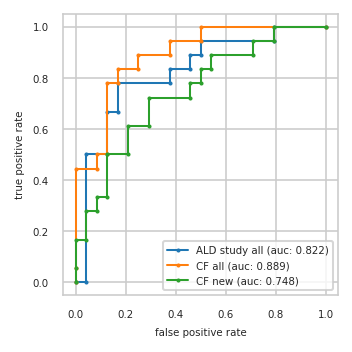

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.500  0.000 0.444  0.000 0.167
3          0.125 0.500  0.083 0.444  0.042 0.167
4          0.125 0.667  0.083 0.500  0.042 0.278
5          0.167 0.667  0.125 0.500  0.083 0.278
6          0.167 0.778  0.125 0.778  0.083 0.333
7          0.375 0.778  0.167 0.778  0.125 0.333
8          0.375 0.833  0.167 0.833  0.125 0.500
9          0.458 0.833  0.250 0.833  0.208 0.500
10         0.458 0.889  0.250 0.889  0.208 0.611
11         0.500 0.889  0.375 0.889  0.292 0.611
12         0.500 0.944  0.375 0.944  0.292 0.722
13         0.792 0.944  0.500 0.944  0.458 0.722
14         0.792 1.000  0.500 1.000  0.458 0.778
15         1.000 1.000  1.000 1.000  0.500 0.778
16           NaN   NaN    NaN   NaN  0.500 0.833
17           NaN   NaN    NaN   NaN  0.542 0.833
18           NaN   NaN    NaN   NaN  0.542 0.889
19           NaN   NaN    NaN   NaN  0.708 0.889
20           NaN   NaN    NaN   NaN  0.708 0.944
21           NaN   NaN    NaN   NaN  0.792 0.944
22           NaN   NaN    NaN   NaN  0.792 1.000
23           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A087X136;P51801,Q99983,Q16799
2,G3V4U0;G3XA98;Q9UBX5,O60512,A0A0J9YW36;Q9NZ72;Q9NZ72-2
3,Q99983,Q14894,Q96GD0
4,P61981,P14174,P31321
5,P04075,P04075,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
6,P14174,Q9Y2T3;Q9Y2T3-3,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,Q9Y2T3;Q9Y2T3-3,P61981,O95497
8,P05413;S4R371,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


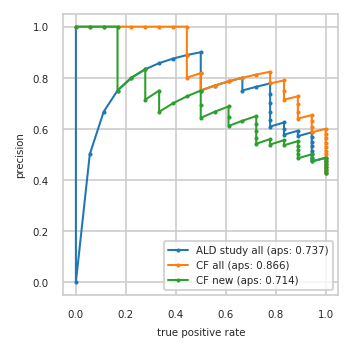

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.571 0.889     0.607 0.944     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.577 0.833     0.654 0.944     0.538 0.778
17         0.600 0.833     0.640 0.889     0.560 0.778
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.609 0.778     0.696 0.889     0.565 0.722
20         0.636 0.778     0.727 0.889     0.591 0.722
21         0.667 0.778     0.714 0.833     0.619 0.722
22         0.700 0.778     0.750 0.833     0.650 0.722
23         0.737 0.778     0.789 0.833     0.632 0.667
24         0.778 0.778     0.778 0.778     0.611 0.611
25         0.765 0.722     0.824 0.778     0.647 0.611
26         0.750 0.667     0.812 0.722     0.688 0.611
27         0.800 0.667     0.800 0.667     0.667 0.556
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.769 0.556     0.769 0.556     0.692 0.500
30         0.750 0.500     0.750 0.500     0.750 0.500
31         0.818 0.500     0.818 0.500     0.727 0.444
32         0.900 0.500     0.800 0.444     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     1.000 0.444     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


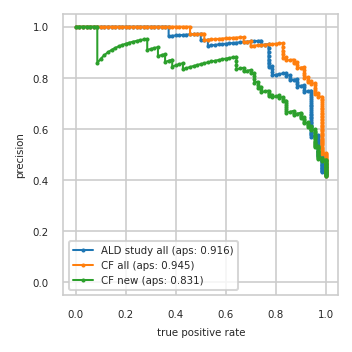

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


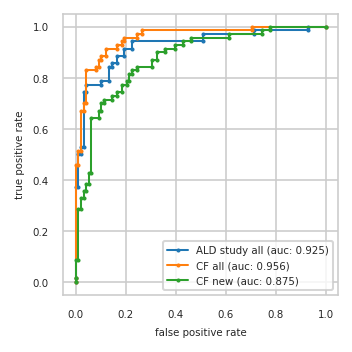

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}